In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Model Creation
* This code utilizes transfer learning to develop a model that detects if the eye is closed or not

In [2]:
# Import required libraries
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

In [3]:
# Directory and class setup
data_dir = "/kaggle/input/mrl-eye-dataset/data/train"
classes = ["awake", "sleepy"]

# Image size for model input
img_size = 224

In [4]:
# Custom Dataset class for loading drowsiness detection images
class DrowsinessDataset(Dataset):
    """
    Custom Dataset class for loading and preprocessing drowsiness detection images.
    
    Args:
        data_dir (str): Directory containing the image data
        classes (list): List of class names
        transform: Optional transforms to be applied to images
    """
    def __init__(self, data_dir, classes, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # Load images and labels from directory
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a single item from the dataset.
        
        Args:
            idx (int): Index of the item
            
        Returns:
            tuple: (transformed image, label)
        """
        img_path = self.data[idx]
        label = self.labels[idx]

        # Load and preprocess the image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
def visualize_dataset(dataset, classes):
    """
    Visualize random samples from an image dataset with their corresponding class labels.

    This function displays 5 random images from the provided dataset in a horizontal layout,
    with their class labels as titles. The images are denormalized before display.

    Args:
        dataset (torch.utils.data.Dataset): The dataset containing image-label pairs.
            Expected format: dataset[i] should return (image, label) where image is a
            normalized tensor with shape (C, H, W) and label is an integer index.
        classes (list): List of class names corresponding to the label indices.
            The length should match the number of unique labels in the dataset.

    Returns:
        None: Displays the plot using matplotlib.pyplot.show()

    Example:
        >>> classes = ['cat', 'dog', 'bird']
        >>> visualize_dataset(my_dataset, classes)

    Note:
        - Assumes images are normalized to [-1, 1] range
        - Uses matplotlib for visualization
        - Displays images in RGB format
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        idx = np.random.randint(len(dataset))
        image, label = dataset[idx]
        # Denormalize from [-1, 1] to [0, 1] range and convert to HWC format
        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(image)
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

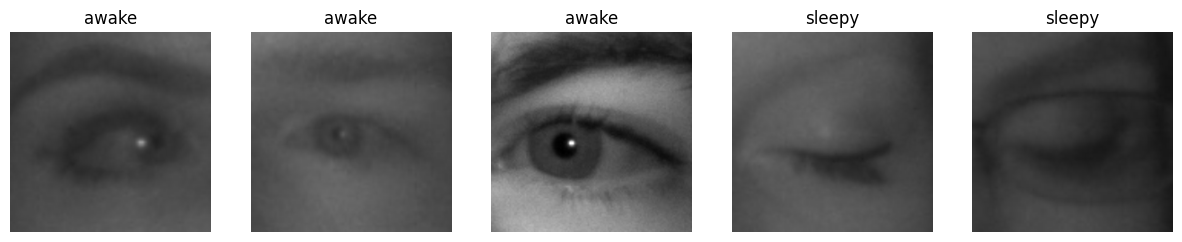

In [6]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create dataset and dataloader
dataset = DrowsinessDataset(data_dir, classes, transform=transform)
visualize_dataset(dataset, classes)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Define the neural network model
class DrowsinessModel(nn.Module):
    """
    Neural network model for drowsiness detection using MobileNetV2 as backbone.
    
    The model uses transfer learning with pretrained MobileNetV2 and modifies
    the final classification layer for binary classification.
    """
    def __init__(self):
        super(DrowsinessModel, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.classifier[1] = nn.Linear(self.base_model.last_channel, 1)  # Binary classification

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

# Initialize model, loss function, and optimizer
model = DrowsinessModel()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [9]:
from tqdm import tqdm

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32).unsqueeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "drowsiness_model.pth")

Epoch 1/10: 100%|██████████| 1592/1592 [07:10<00:00,  3.70it/s]


Epoch [1/10], Loss: 0.0526


Epoch 2/10: 100%|██████████| 1592/1592 [05:09<00:00,  5.15it/s]


Epoch [2/10], Loss: 0.0420


Epoch 3/10: 100%|██████████| 1592/1592 [05:08<00:00,  5.16it/s]


Epoch [3/10], Loss: 0.0391


Epoch 4/10: 100%|██████████| 1592/1592 [05:11<00:00,  5.12it/s]


Epoch [4/10], Loss: 0.0359


Epoch 5/10: 100%|██████████| 1592/1592 [05:11<00:00,  5.11it/s]


Epoch [5/10], Loss: 0.0329


Epoch 6/10: 100%|██████████| 1592/1592 [05:11<00:00,  5.12it/s]


Epoch [6/10], Loss: 0.0318


Epoch 7/10: 100%|██████████| 1592/1592 [05:09<00:00,  5.14it/s]


Epoch [7/10], Loss: 0.0291


Epoch 8/10: 100%|██████████| 1592/1592 [05:08<00:00,  5.16it/s]


Epoch [8/10], Loss: 0.0276


Epoch 9/10: 100%|██████████| 1592/1592 [05:08<00:00,  5.15it/s]


Epoch [9/10], Loss: 0.0257


Epoch 10/10: 100%|██████████| 1592/1592 [05:10<00:00,  5.12it/s]


Epoch [10/10], Loss: 0.0243


In [23]:
# Calculate accuracy on the test dataset
correct = 0
total = 0
model.eval()

test_data_dir = "/kaggle/input/mrl-eye-dataset/data/test"
test_dataset = DrowsinessDataset(data_dir, classes, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc = "Accuracy:"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Accuracy:: 100%|██████████| 1592/1592 [03:03<00:00,  8.66it/s]

Training Accuracy: 99.43%


In [26]:
# Visualize some images from the dataset
def visualize_dataset_predictions(dataset, model, classes):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    model.eval()
    for i in range(5):
        idx = np.random.randint(len(dataset))
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(image_tensor).item()
        predicted_class = "Awake" if prediction < 0.5 else "Sleepy"

        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize to [0, 1]
        axes[i].imshow(image)
        axes[i].set_title(f"True: {classes[label]}\nPred: {predicted_class}")
        axes[i].axis('off')
    plt.show()

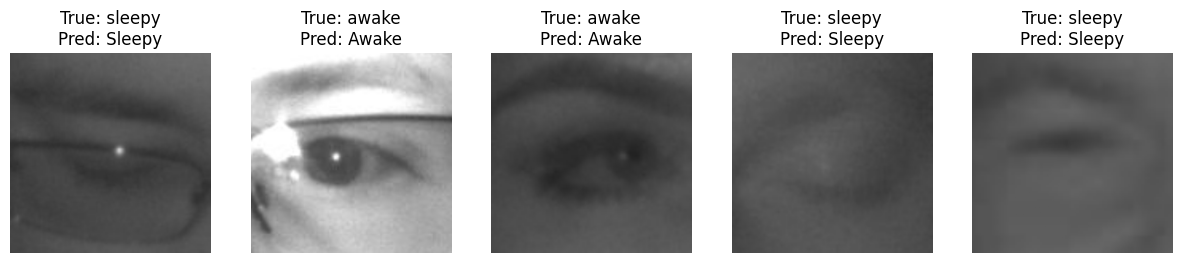

Prediction Probability: 0.9999998807907104
Prediction: Sleepy


In [25]:
# Visualize predictions on multiple images
visualize_dataset_predictions(dataset, model, classes)

# Model testing on a single image
model.eval()
img_path = "/kaggle/input/mrl-eye-dataset/data/train/sleepy/s0001_00011_0_0_0_0_0_01.png"
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Apply the same transformations
image_tensor = transform(image).unsqueeze(0).to(device)

# Make prediction
with torch.no_grad():
    prediction = model(image_tensor).item()
    print("Prediction Probability:", prediction)
    print("Prediction:", "Awake" if prediction < 0.5 else "Sleepy")